# Data Exploration and Multivariable Analysis

This notebook will explore different exploration tools in order to determine that the data at hand is adequate for what we plan to use it -- in this case, a classification of the presence of organized crime in a given Mexican state from 2010 to 2016.

First, I'll read in the data we've been working with and impute with zero (which is the same as median imputation in our case), since it's what seemed to make the most sense from the previous notebook.

In [181]:
import missing_data_code as mdc
import exploration_pca_ca as epc
import jellyfish
import importlib
importlib.reload(mdc)
importlib.reload(epc)

<module 'exploration_pca_ca' from '/Users/mariomoreno/Desktop/ML Projects/Mexico OC/exploration_pca_ca.py'>

In [106]:
# Reading in data
df = mdc.reading_in('data/Mexico_Final.xlsx')

In [107]:
mdc.impute_zero(df, {'costa_km':0}).head()

,entidad,year,alumnos_inscritos_hs,hombres_inscritos_hs,mujeres_inscritas_hs,maestros_hs,escuelas_hs,convenios_trabajo_no_juicio,conflictos_trabajo,emplazamientos_huelga,...,prod_zinc_t,prod_coque_t,prod_fierropellets_t,prod_azufre_t,prod_barita_t,prod_fluorita_t,altitud,costa_km,municipios,pop
0,Aguascalientes,2010,40129,19250,20879,2727,144,2698,3239,325,...,0.0,0.0,3883423.0,0.0,0.0,0.0,1870,0.0,11,1195787
1,Baja California,2010,107624,53692,53932,6192,271,2342,9353,3241,...,0.0,0.0,3883423.0,0.0,0.0,0.0,3,1493.0,5,3224843
2,Baja California Sur,2010,23247,11780,11467,1588,76,1255,1660,296,...,0.0,0.0,3883423.0,0.0,0.0,0.0,10,2131.0,5,649616
3,Campeche,2010,28350,14349,14001,1975,106,3373,1179,144,...,0.0,0.0,3883423.0,0.0,0.0,0.0,10,425.0,11,836747
4,Coahuila de Zaragoza,2010,82553,41397,41156,6219,330,23331,7867,545,...,0.0,1648709.0,2567865.0,0.0,22161.0,121833.0,1700,0.0,38,2782012


In [108]:
cols = mdc.find_missing_cols(df)

In [109]:
# loop to pull out the missing columns from the list above# 
cols_impute = []
for c in cols:
    cols_impute.append(c[0])

In [110]:
working_df = mdc.single_imputation(df, 'median', cols_impute)

### 1) Quick Data Exploration 

Part of the analysis is determining certain components of our data, which means doing a quick exploration of how different columns and states relate to each other. This will hopefully uncover outliers, highly correlated variables, and other worthwhile findings. Once this is done, we'll move on to the next step which is a quick standardization of the variables and then PCA and Cluster Analysis


Summary stats for entidad
count                           224
unique                           32
top       Baja California          
freq                              7
Name: entidad, dtype: object


Summary stats for year
count     224.000000
mean     2013.000000
std         2.004479
min      2010.000000
25%      2011.000000
50%      2013.000000
75%      2015.000000
max      2016.000000
Name: year, dtype: float64


Summary stats for alumnos_inscritos_hs
count       224.000000
mean     139023.571429
std      116544.209387
min       23247.000000
25%       62133.250000
50%      108420.500000
75%      158046.250000
max      640965.000000
Name: alumnos_inscritos_hs, dtype: float64


Summary stats for hombres_inscritos_hs
count       224.000000
mean      69030.053571
std       57721.462175
min       11567.000000
25%       30118.750000
50%       54462.000000
75%       78666.500000
max      314509.000000
Name: hombres_inscritos_hs, dtype: float64


Summary stats for mujeres_inscritas_hs
cou

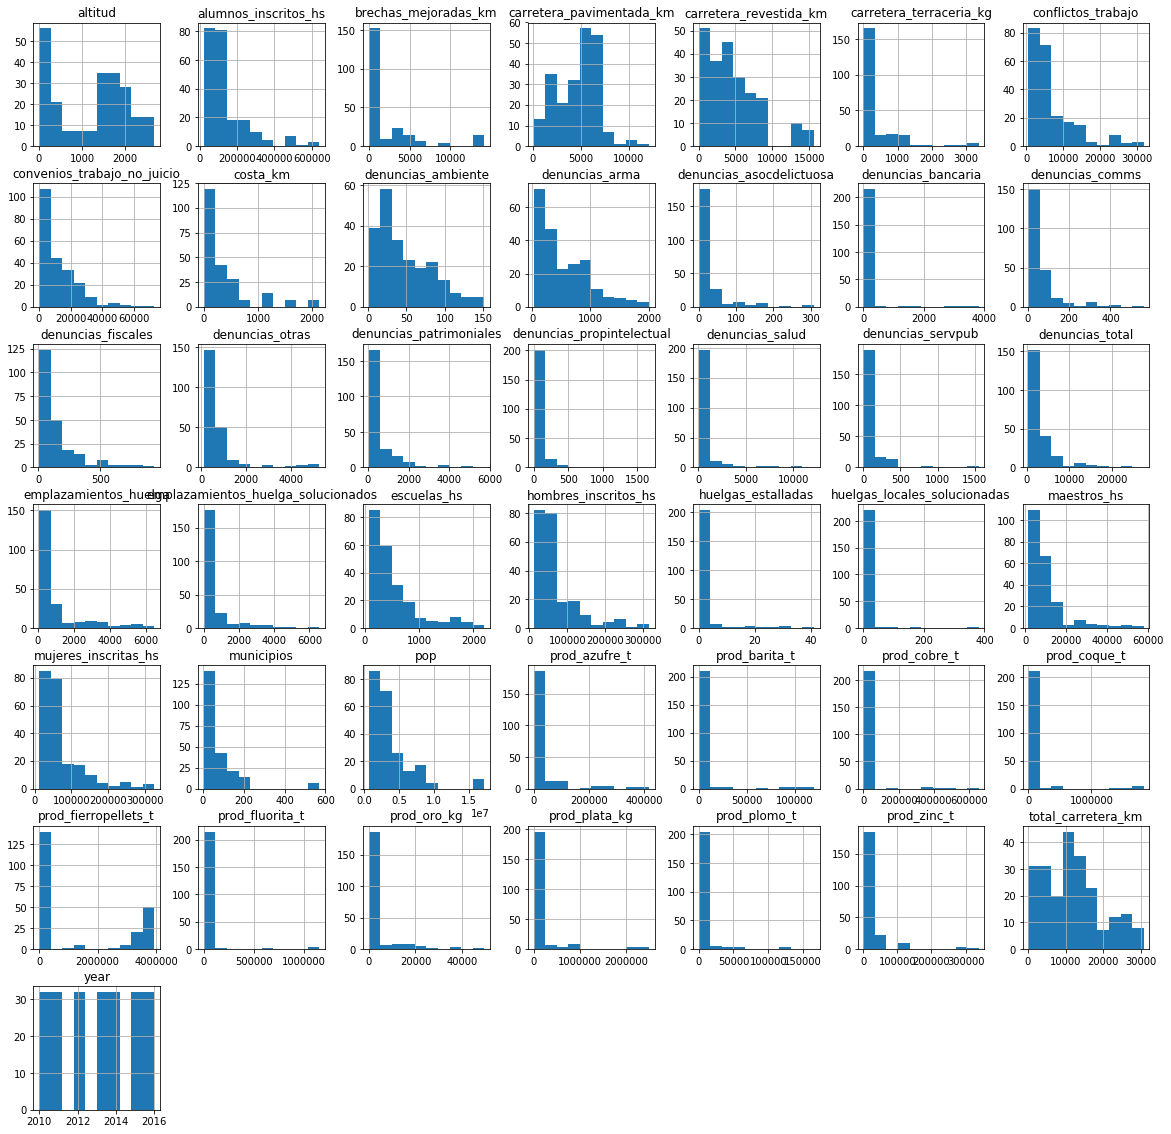

In [111]:
epc.explore_data(working_df)

Not that much to note from the histograms or descriptive statistics. I'll dive a little deeper in to outliers, as there are appears to be some...but that might be a function of the disparate populations within states and the large number of population dependent variables.

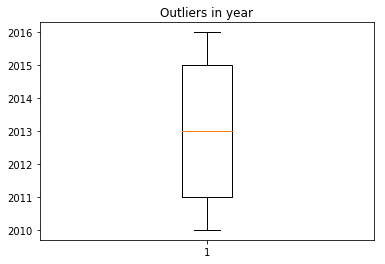

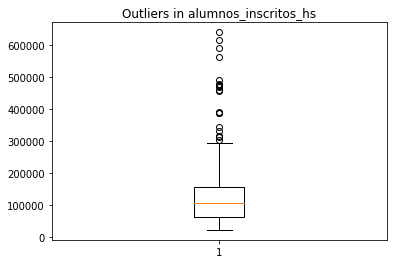

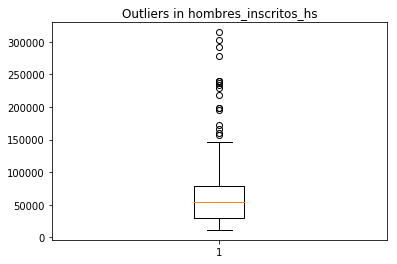

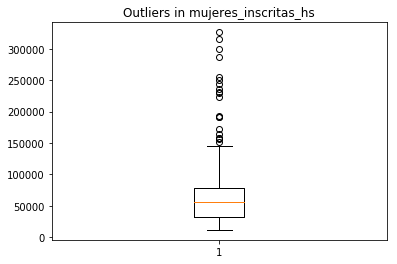

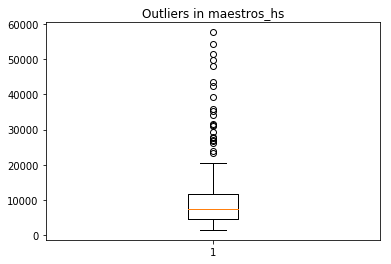

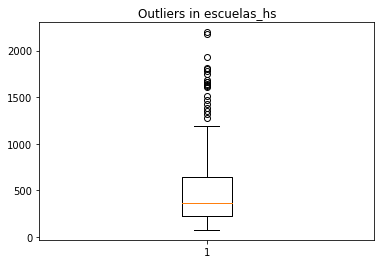

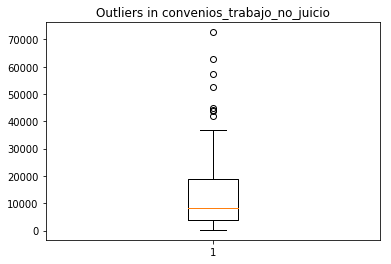

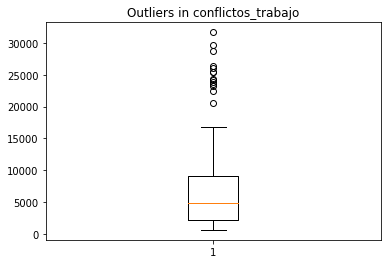

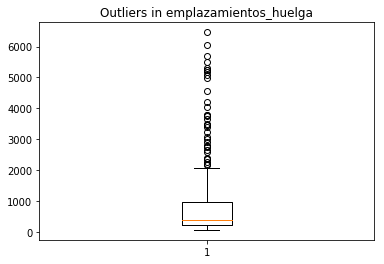

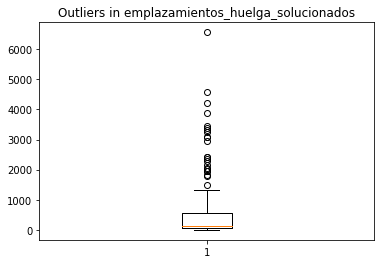

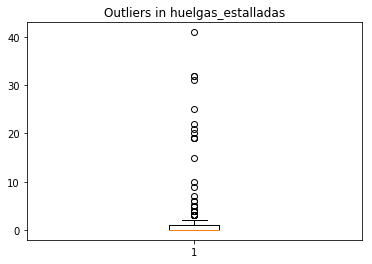

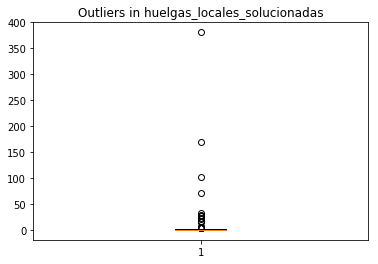

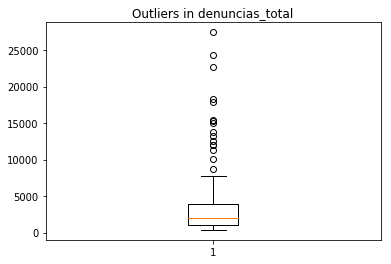

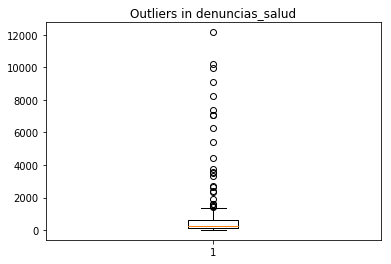

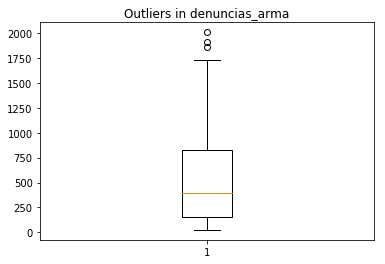

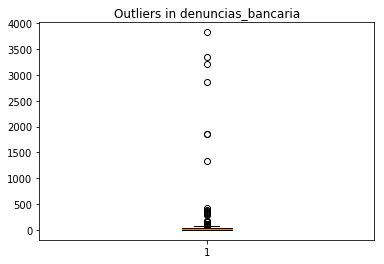

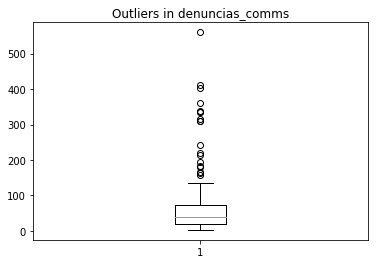

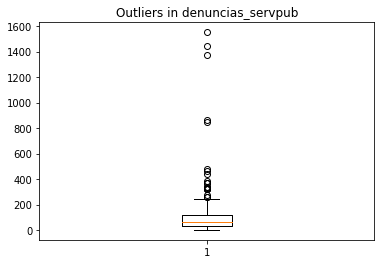

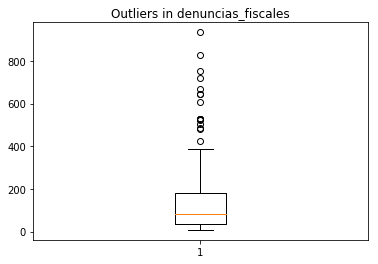

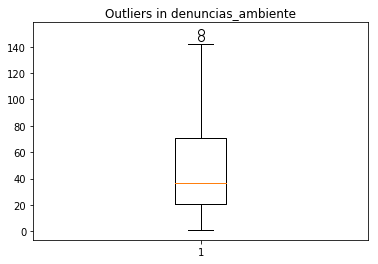

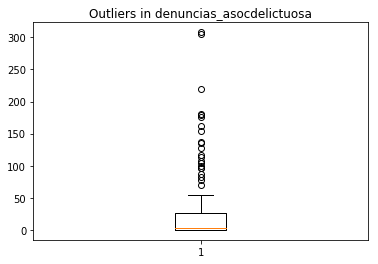

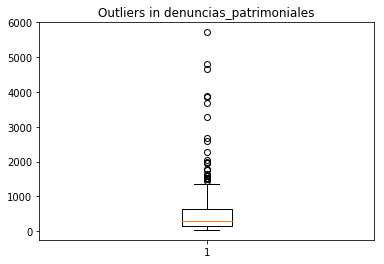

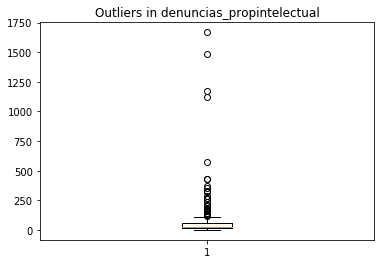

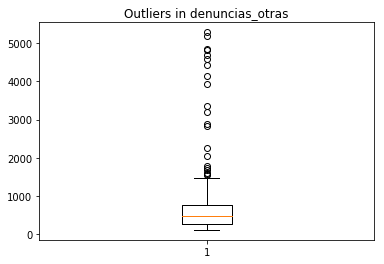

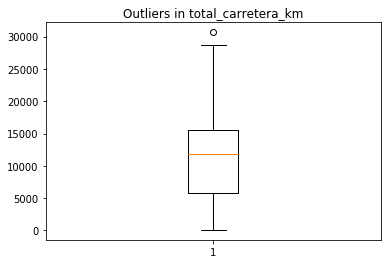

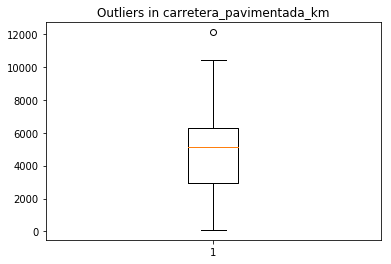

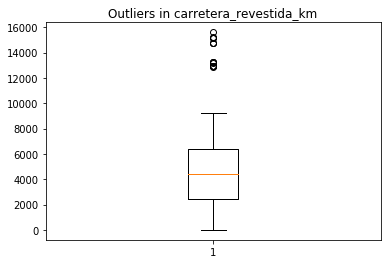

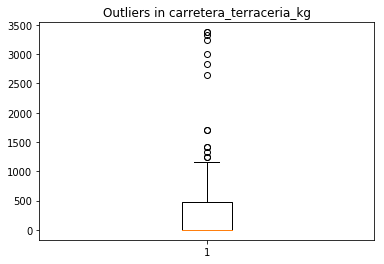

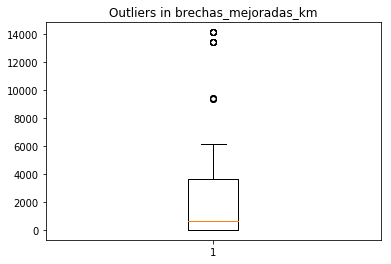

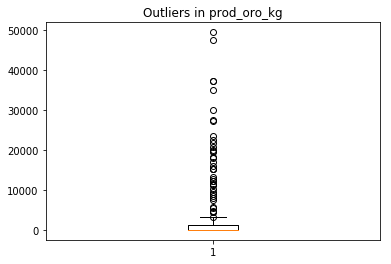

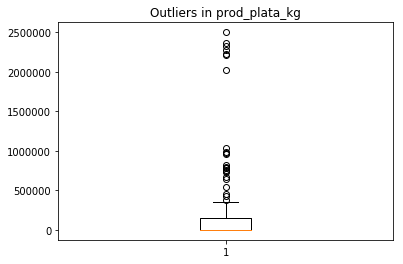

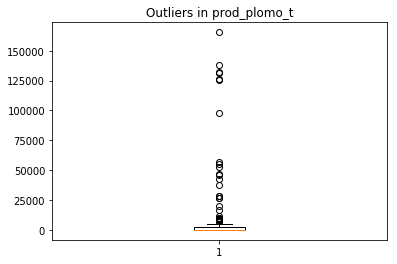

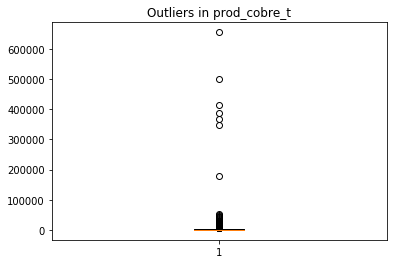

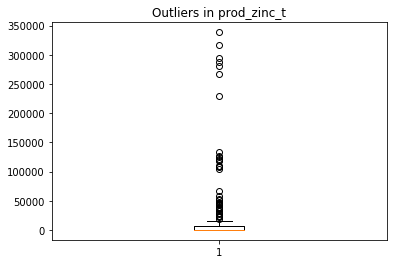

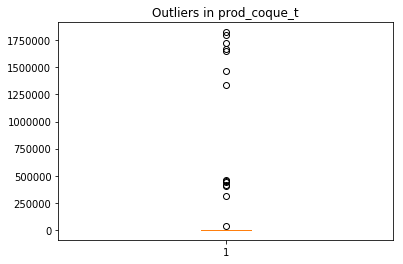

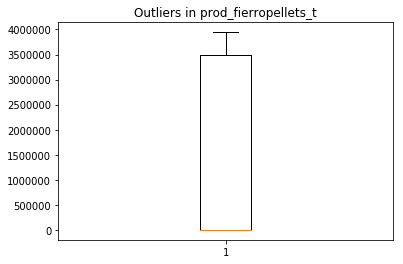

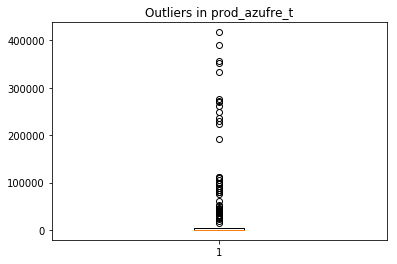

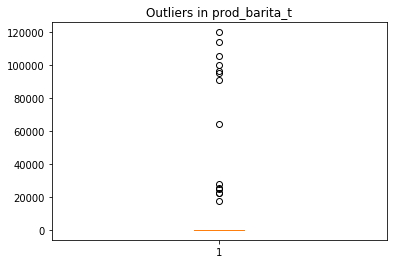

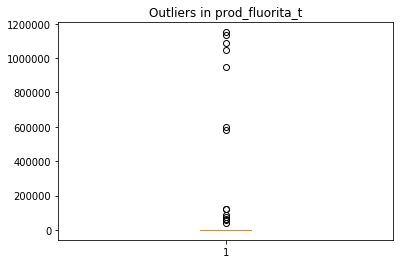

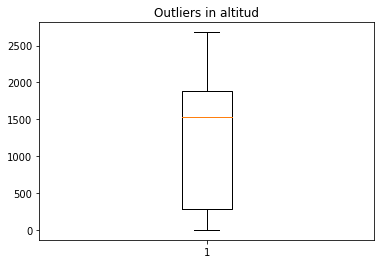

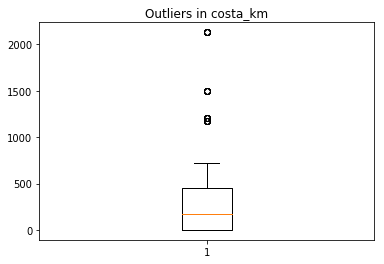

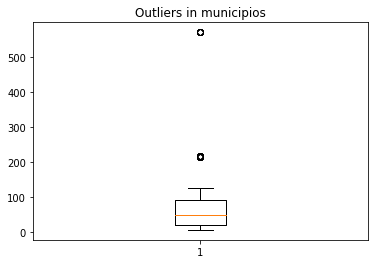

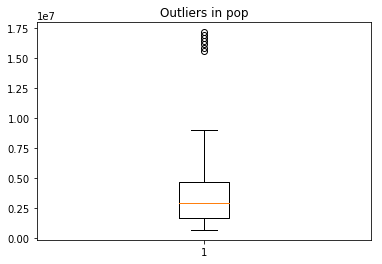

In [112]:
epc.box_plot(working_df)

Most variables have outliers, but I can generally group the variables with outliers in two: population dependent variables and metal production variables. 

Given that a lot of Mexican states are more populous than others and some states have the natural resources to produce metals, the outliers make sense and might not be indicative of flawed data. To be extra sure, I think it would be appropriate to convert all the population dependent variables to per capita and, after the PCA and Cluster Analysis, likely discretize. I'll drop the population variable after the per capita change.

Thankfully, our population dependent columns are all in order between indexes 2-24. It should be pretty straightforward dividing them by population.

In [113]:
# per capita calculation
working_df.iloc[:,2:24] = working_df.iloc[:,2:24].div(working_df.iloc[:,-1], axis=0)
del working_df['pop']
working_df.head()

,entidad,year,alumnos_inscritos_hs,hombres_inscritos_hs,mujeres_inscritas_hs,maestros_hs,escuelas_hs,convenios_trabajo_no_juicio,conflictos_trabajo,emplazamientos_huelga,...,prod_cobre_t,prod_zinc_t,prod_coque_t,prod_fierropellets_t,prod_azufre_t,prod_barita_t,prod_fluorita_t,altitud,costa_km,municipios
0,Aguascalientes,2010,0.033559,0.016098,0.017460,0.002281,0.000120,0.002256,0.002709,0.000272,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,1870,0.0,11
1,Baja California,2010,0.033373,0.016649,0.016724,0.001920,0.000084,0.000726,0.002900,0.001005,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,3,1493.0,5
2,Baja California Sur,2010,0.035786,0.018134,0.017652,0.002445,0.000117,0.001932,0.002555,0.000456,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,10,2131.0,5
3,Campeche,2010,0.033881,0.017149,0.016733,0.002360,0.000127,0.004031,0.001409,0.000172,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,10,425.0,11
4,Coahuila de Zaragoza,2010,0.029674,0.014880,0.014794,0.002235,0.000119,0.008386,0.002828,0.000196,...,0.0,0.0,1648709.0,2567865.0,0.0,22161.0,121833.0,1700,0.0,38


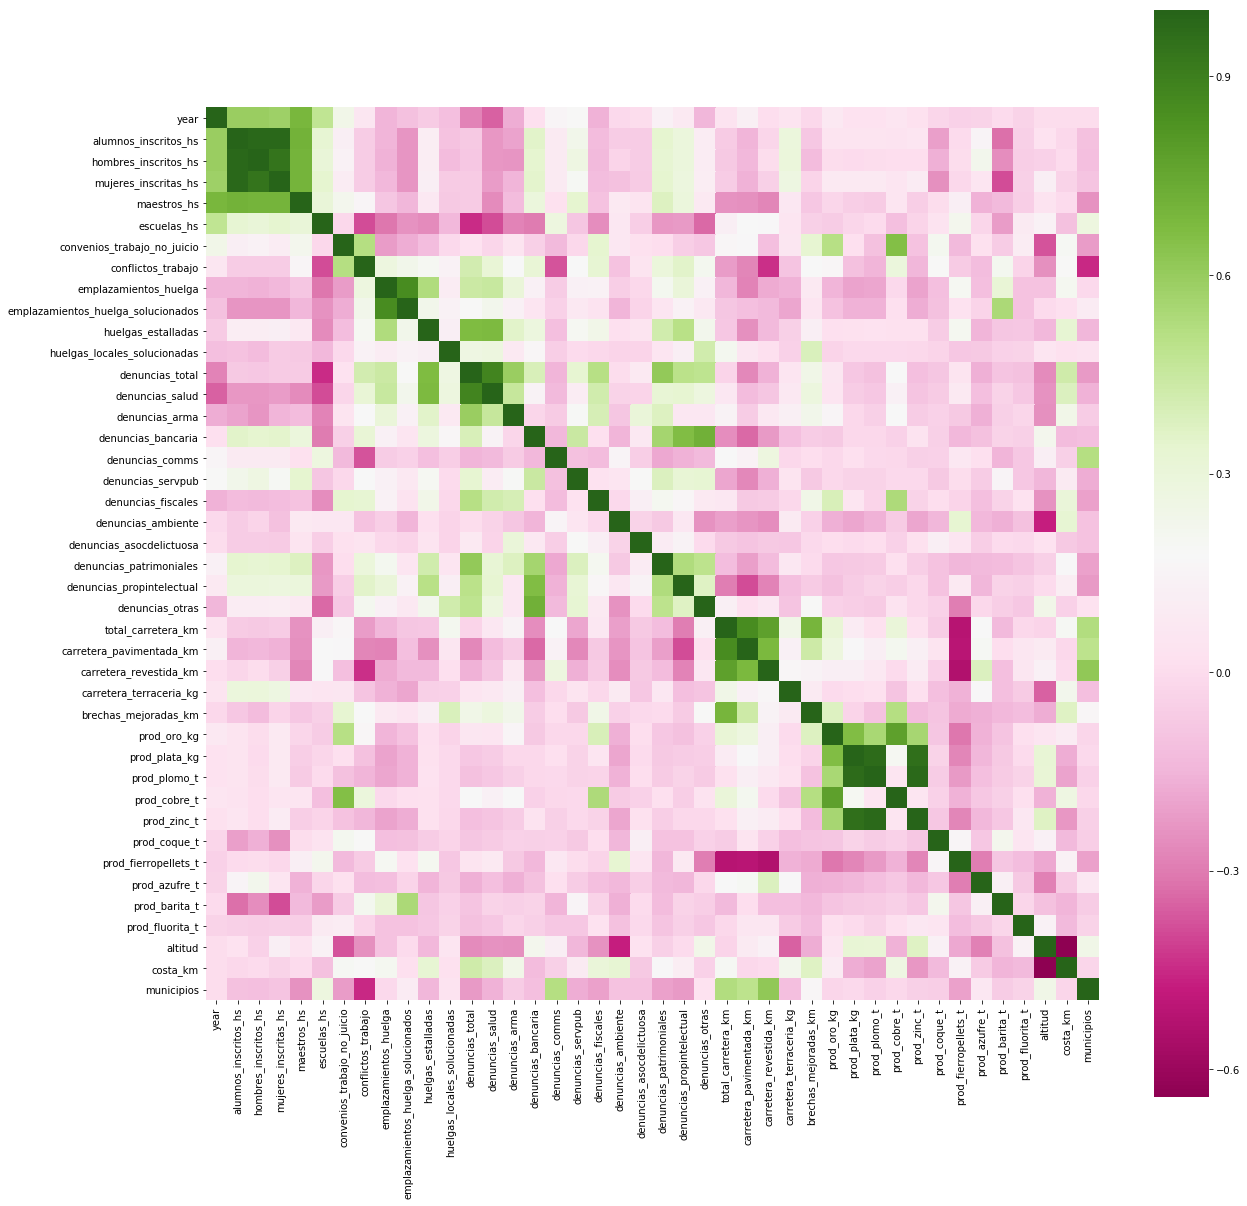

In [114]:
epc.explore_potential_correlations(working_df)

A couple of things to note from the correlation heatmap:
- There's significant correlation between all the education variables, so we'd expect them to group together in a Principal Components Analysis
- There's generally a positive correlation between several of the denuncias variables, so we'd expect them to once again group together under a Principal Component Analysis. We'd also expect the carretera variables to group together.
- There's positive correlation between the production of different metals variables, but only among the more common ones like gold, silver, copper, which is interesting to say the least. Curious to see if the group together in PCA or not.

### 2) Principal Components Analysis 

The first step in doing this analysis is standardizing all the variables, which is different than normalizing theoretically and functionally. This is necessary since a lot of machine learning algorithms, PCA included, are optimized for standardized variables -- or variables that have the same units across them. 
- Theoretically, standardizing transforms the variables onto the unit scale (mean = 0, variance = 1) which measures how variables are distributed from the mean. Functionally, I'm only doing this to implement the PCA algorithm which requires it. I'll keep working_df intact for the next step, which is normalization.
- Theoretically, normalizing transforms the variables into the same units, and standardization is an option in normalizing but not the only one. You can normalize by rank, z-score, and more. Functionally, I'll do that in the next step.

It's important to note that these methods I'll be deploying are largely unsupervised learning methods that try to tease out any similarities between our columns (variables) and rows. In doing so, I hope to better understand the data that we have at hand.

I've been having considerable trouble in getting entidad to show up on PCA and Cluster graphs, so I'll be turning the states into integers. I'll create a dictionary to assign values and use a loop that utilizes jaro-winkler to match up the different strings. From there, I'll store the new values in a list that I'll turn into the new entidad column

In [115]:
replacing = {'Aguascalientes':1, 'Baja California':2, 'Baja California Sur':3, 'Campeche':4, 'Coahuila de Zaragoza':5, 'Colima':6, 'Chiapas':7, 'Chihuahua':8, 'Ciudad de México /b':9, 'Durango':10, 'Guanajuato':11, 'Guerrero':12, 'Hidalgo':13, 'Jalisco':14, 'México':15, 'Michoacán de Ocampo':16, 'Morelos':17, 'Nayarit':18, 'Nuevo León':19, 'Oaxaca':20, 'Puebla':21, 'Querétaro':22, 'Quintana Roo':23, 'San Luis Potosí':24, 'Sinaloa':25, 'Sonora':26, 'Tabasco':27, 'Tamaulipas':28, 'Tlaxcala':29, 'Veracruz de Ignaxio de la Llave':30, 'Yucatán':31, 'Zacatecas':32} 

In [116]:
new_col = []
for c in working_df['entidad']:
    for state, rep in replacing.items():
        if jellyfish.jaro_distance(c.strip(), state) > 0.95:
            new_col.append(state)

The code below turns states into their clean state values. It can easily be modified into integer values if need be.

In [117]:
import pandas as pd
working_df['entidad'] = pd.Series(new_col)

I'll carry my data divided by year for this next part

This loop does several things: for every year in our dataset, it 
- stores the original dataframe
- a dataframe with a multiindex without entidad and year
- **pca** which is a PCA class that is our reduced data with the components we want
- **y_pca** which is an array of the principal components as vectors
- the string version of the year so that we know what year it's referring to

It appends this to a list as tuples so that we have all the information we need per year in one location.

In [144]:
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016]
dfs = []
for year in years:
    df = working_df[working_df['year']==year].reset_index(drop=True)
    new = df.set_index(['entidad', 'year'])
    pca, y_pca = epc.pca(new, 15)
    name = str(year)
    dfs.append((df, new, pca, y_pca, name))

In [145]:
dfs[1]

(                            entidad  year  alumnos_inscritos_hs  \
 0                    Aguascalientes  2011              0.033957   
 1                   Baja California  2011              0.034473   
 2               Baja California Sur  2011              0.036502   
 3                          Campeche  2011              0.033882   
 4              Coahuila de Zaragoza  2011              0.030209   
 5                            Colima  2011              0.035797   
 6                           Chiapas  2011              0.039909   
 7                         Chihuahua  2011              0.032499   
 8               Ciudad de México /b  2011              0.043872   
 9                           Durango  2011              0.038828   
 10                       Guanajuato  2011              0.029340   
 11                         Guerrero  2011              0.032588   
 12                          Hidalgo  2011              0.038896   
 13                          Jalisco  2011      

In [146]:
dfs[3][0].head()

,entidad,year,alumnos_inscritos_hs,hombres_inscritos_hs,mujeres_inscritas_hs,maestros_hs,escuelas_hs,convenios_trabajo_no_juicio,conflictos_trabajo,emplazamientos_huelga,...,prod_cobre_t,prod_zinc_t,prod_coque_t,prod_fierropellets_t,prod_azufre_t,prod_barita_t,prod_fluorita_t,altitud,costa_km,municipios
0,Aguascalientes,2013,0.041248,0.020386,0.020862,0.003968,0.000178,0.003508,0.002123,0.000115,...,0.0,0.0,0.0,3777789.0,0.0,0.0,0.0,1870,0.0,11
1,Baja California,2013,0.039608,0.019741,0.019867,0.002903,0.000099,0.001106,0.003080,0.001115,...,0.0,0.0,0.0,3777789.0,0.0,0.0,0.0,3,1493.0,5
2,Baja California Sur,2013,0.041017,0.020677,0.020340,0.003431,0.000139,0.004025,0.002331,0.000351,...,0.0,0.0,0.0,3777789.0,0.0,0.0,0.0,10,2131.0,5
3,Campeche,2013,0.037386,0.019128,0.018259,0.003545,0.000141,0.005921,0.001187,0.000187,...,0.0,0.0,0.0,3777789.0,0.0,0.0,0.0,10,425.0,11
4,Coahuila de Zaragoza,2013,0.033372,0.017293,0.016079,0.003315,0.000136,0.008827,0.003130,0.000131,...,0.0,0.0,1799408.0,2858312.0,0.0,22483.0,74996.0,1700,0.0,38


Our next function creates a pandas dataframe where the columns are our principal components, and maintains our target variables. 

The function not only creates the pandas dataframe, but also explains how much variance is explained by the principal components themselves.

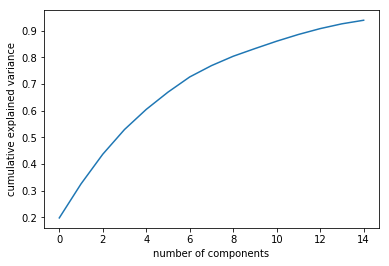

Variance explained for first 15 components in 2010
[ 0.19818029  0.12756973  0.11113762  0.09255059  0.0754179   0.06462679
  0.05694277  0.04243574  0.0350921   0.02874216  0.02768583  0.0251611
  0.02197877  0.01796527  0.0133689 ]


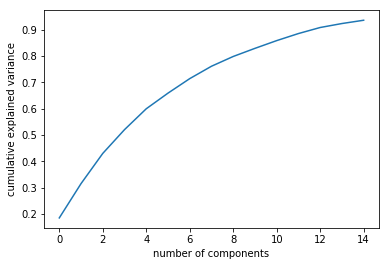

Variance explained for first 15 components in 2011
[ 0.18540827  0.13029112  0.11470805  0.09029665  0.07927192  0.05937951
  0.05510716  0.04704736  0.03709014  0.03084562  0.02942213  0.02680535
  0.02296778  0.01506416  0.01250792]


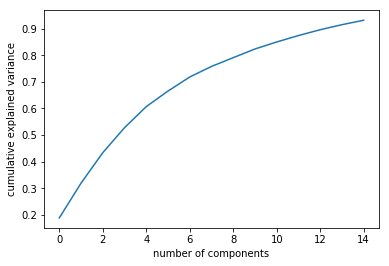

Variance explained for first 15 components in 2012
[ 0.18845307  0.13064499  0.11456275  0.09397384  0.07922347  0.05859495
  0.05288047  0.0397196   0.03288756  0.03270744  0.0263915   0.02411445
  0.02191206  0.01895041  0.01670932]


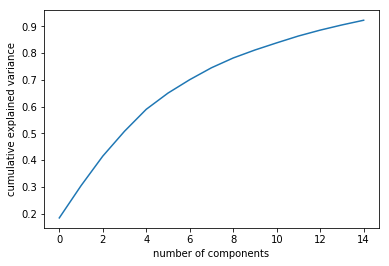

Variance explained for first 15 components in 2013
[ 0.18408322  0.12026182  0.11041371  0.0928731   0.08200397  0.06050743
  0.05007326  0.04447862  0.03652811  0.02980161  0.02664186  0.02557363
  0.02193942  0.01936386  0.01755016]


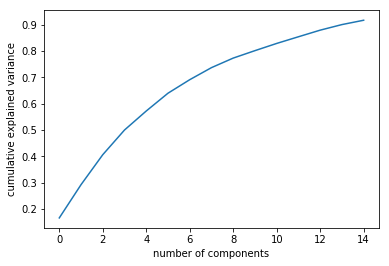

Variance explained for first 15 components in 2014
[ 0.16663197  0.12629481  0.11380908  0.09374562  0.07218875  0.06756732
  0.05133136  0.04578008  0.03625745  0.02828088  0.02735967  0.02533489
  0.02508773  0.02115029  0.0164981 ]


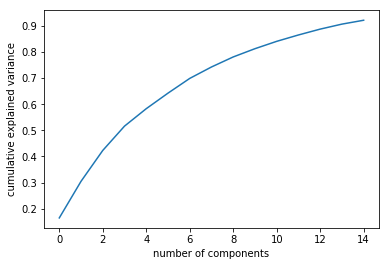

Variance explained for first 15 components in 2015
[ 0.16486679  0.14010937  0.11816027  0.0930243   0.06675086  0.05948056
  0.05636928  0.04373566  0.03841487  0.03157471  0.02814351  0.02435472
  0.02242489  0.01910181  0.01484393]


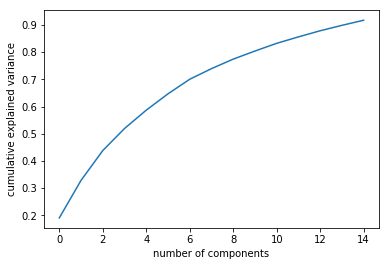

Variance explained for first 15 components in 2016
[ 0.19060322  0.1380198   0.10953756  0.08105885  0.06746975  0.06005955
  0.05357256  0.0389746   0.03498979  0.02977174  0.02830712  0.02363468
  0.02254305  0.01993703  0.01872009]


In [147]:
pca_dfs = []
for df in dfs:
    pca_df = epc.pca_df(df[0], df[2], df[3], 15, 'entidad', 'year', df[4])
    pca_dfs.append(pca_df)

This is a fairly weak Principal Component Analysis -- reducing the dimensionality to two columns only helps explain about 29-34% of the variance for any given year. This means that there's likely an issue with our original data. Once we get to 15 components, then we're talking about capturing 90% of the variance for pretty much all years.

In [149]:
pca_dfs[4].head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,entidad,year
0,0.947763,-1.412382,-3.236312,1.423916,0.449280,-0.016631,-1.193732,-0.950023,-1.326893,0.777908,0.431422,-1.334785,0.387079,-0.379883,-0.867015,Aguascalientes,2014
1,7.217182,-1.770532,2.105049,-1.990227,-2.583756,-1.751033,1.358416,4.100841,-0.673395,-1.344785,1.007202,0.677805,0.359092,-0.821512,0.026252,Baja California,2014
2,1.048807,-2.817662,0.332359,0.059924,1.360714,-2.140751,-0.197525,1.617039,0.019612,0.844132,0.526536,0.859647,-0.727356,0.886686,-1.247078,Baja California Sur,2014
3,-0.591587,-2.957580,0.026570,0.776195,0.502236,-2.025541,-0.175746,-1.140296,1.816986,0.109989,0.097878,1.606134,-1.055098,-1.192073,-0.180815,Campeche,2014
4,-1.553250,-2.429469,0.736446,1.847071,1.325311,3.177309,-0.966564,-0.318563,-1.334582,-1.209306,4.271190,0.038541,-0.583909,-0.196764,1.323508,Coahuila de Zaragoza,2014


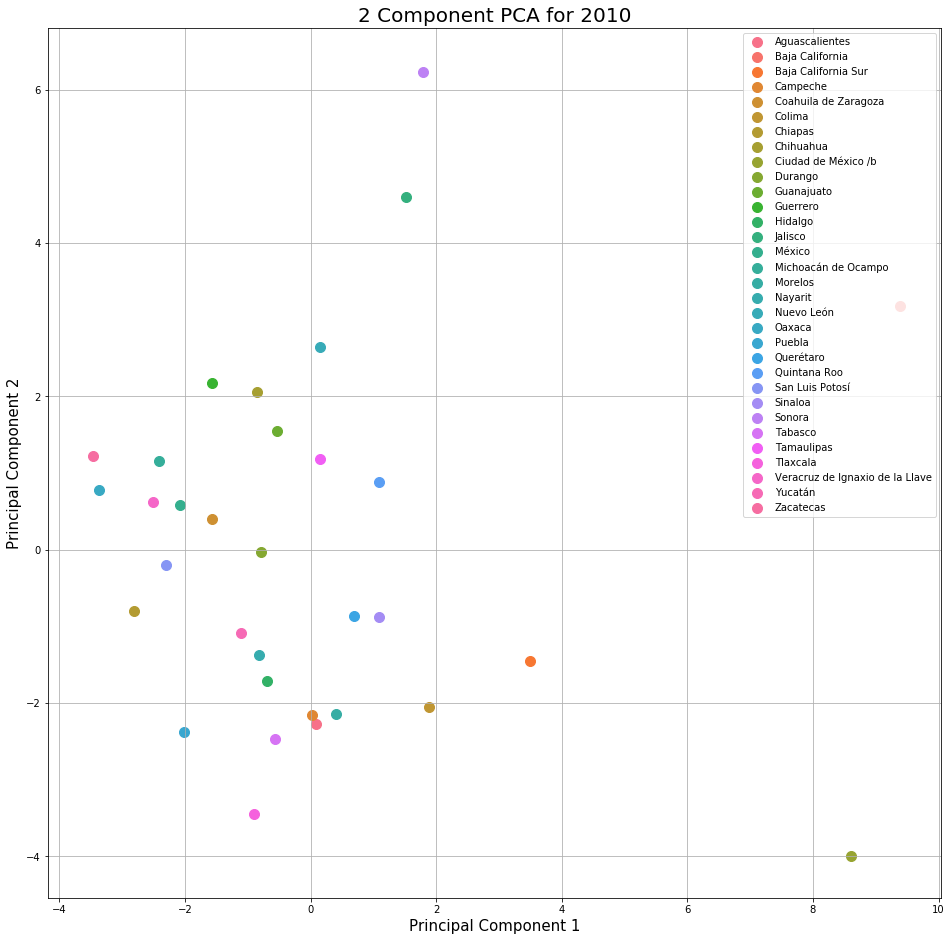

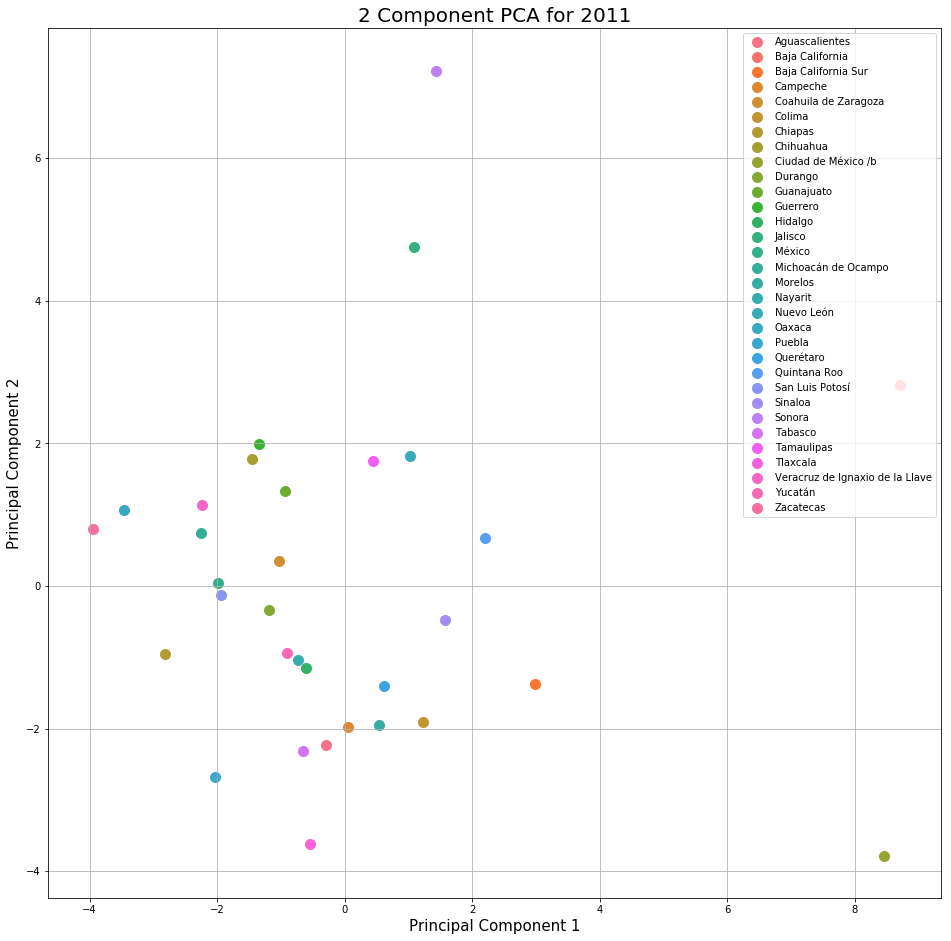

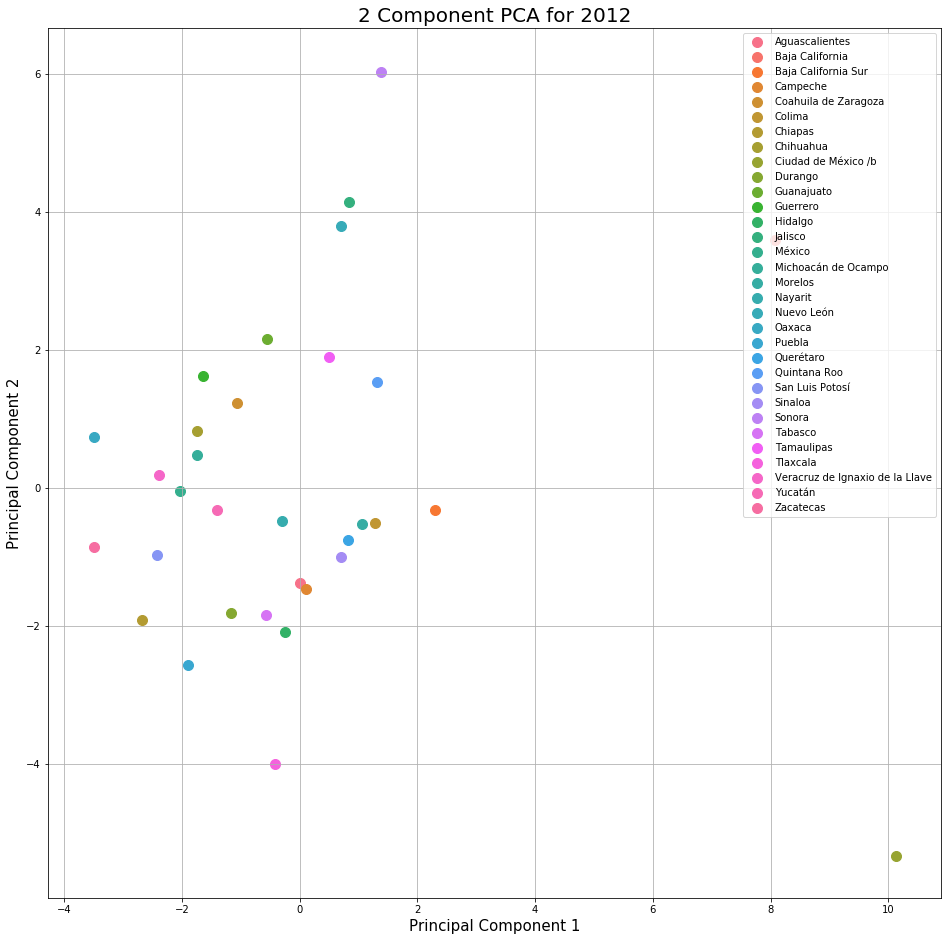

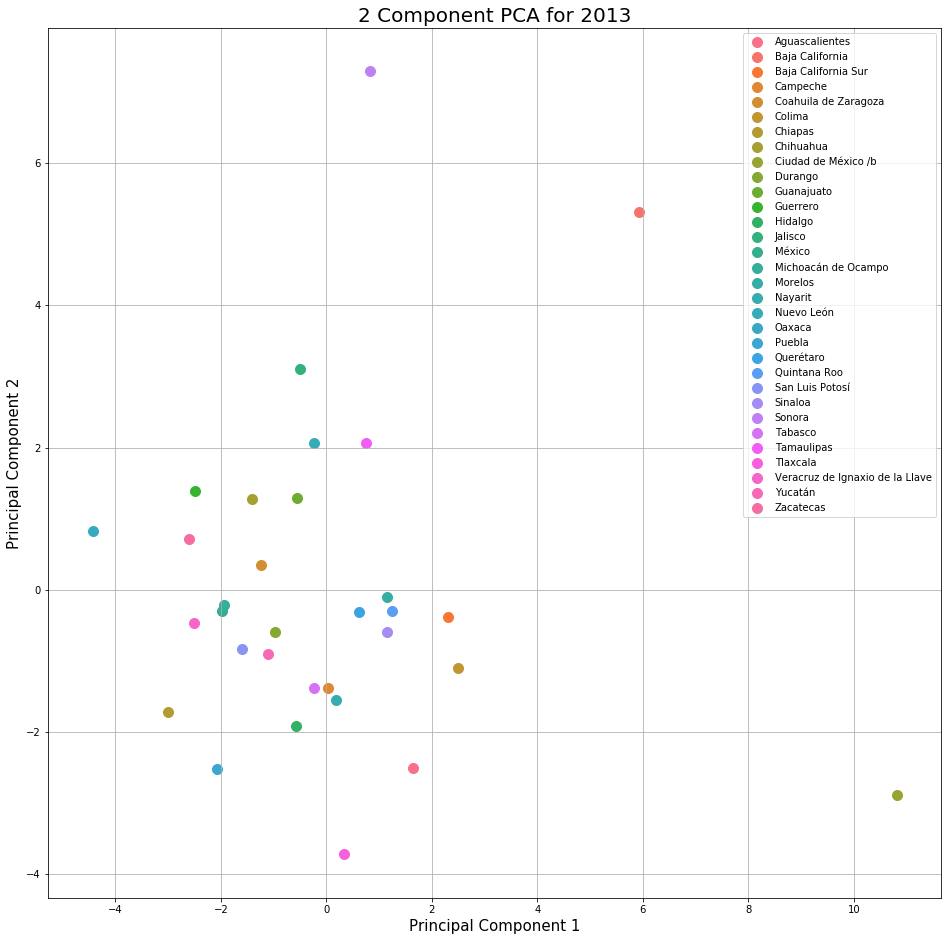

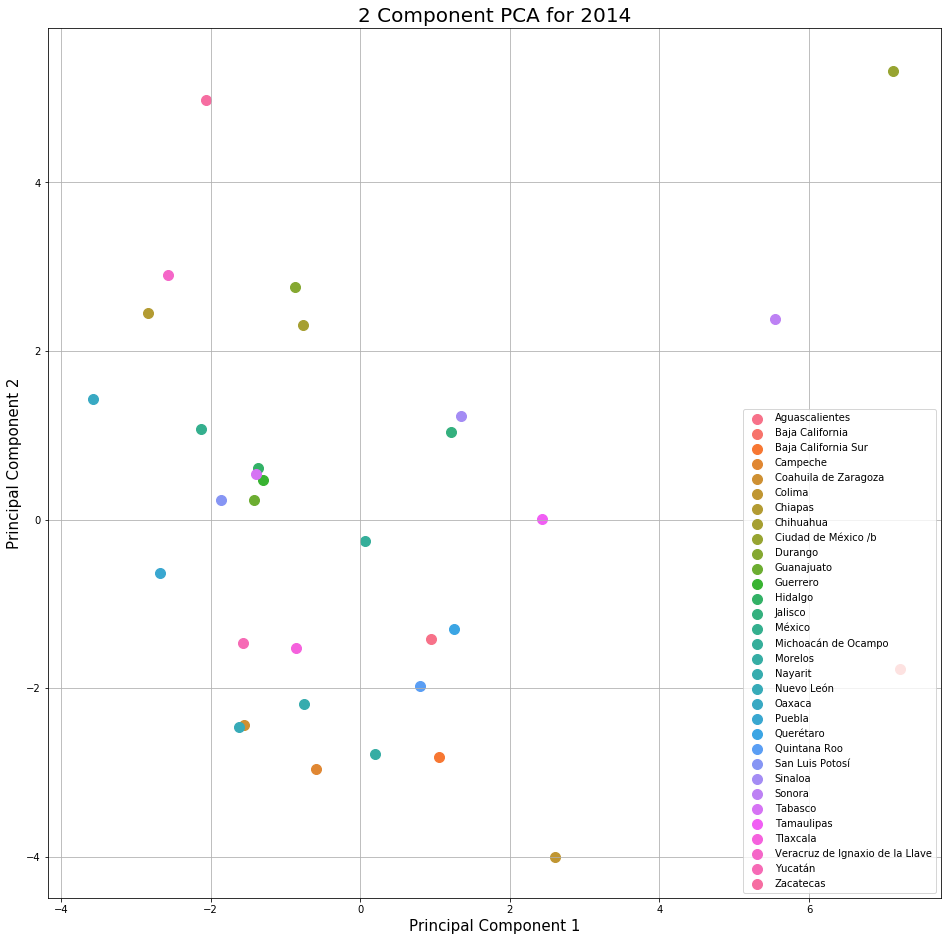

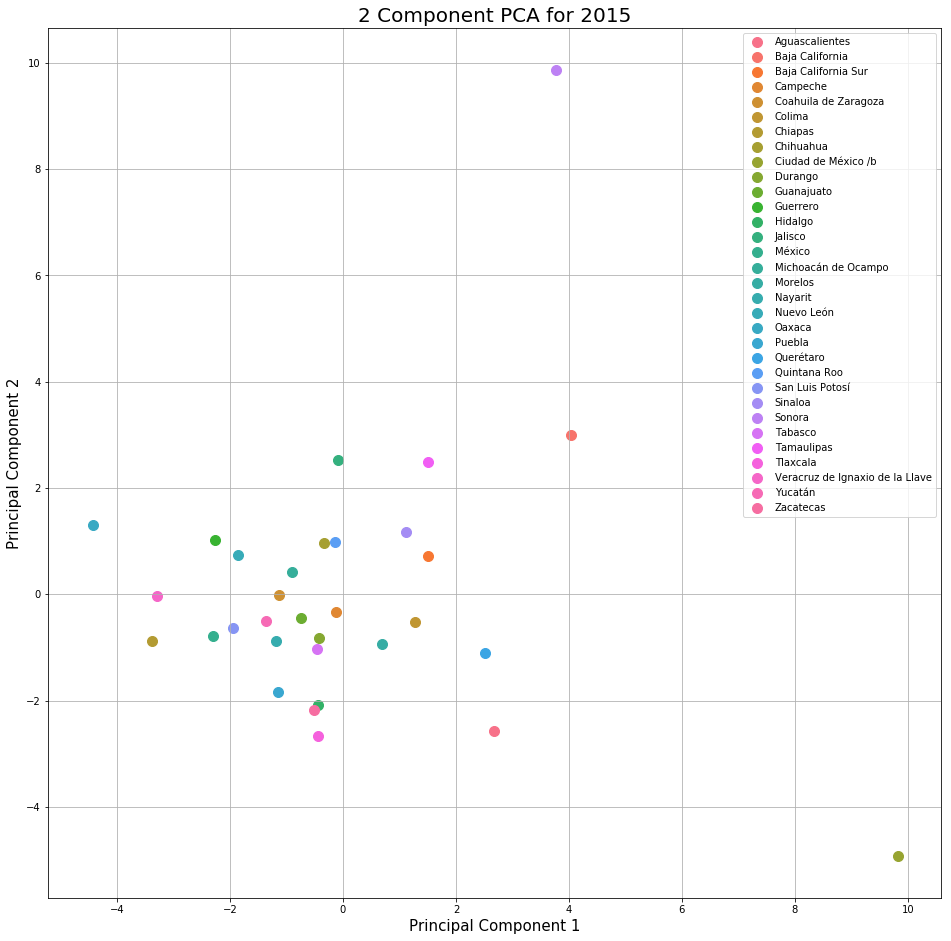

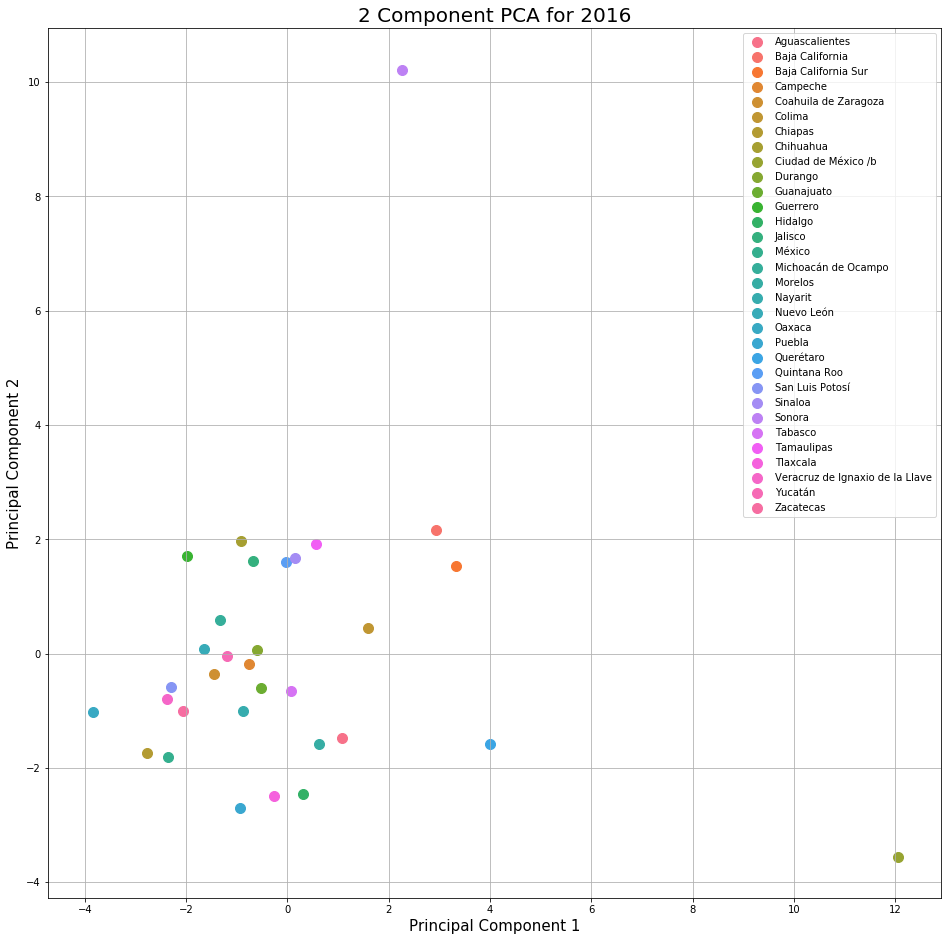

In [154]:
for p in pca_dfs:
    epc.two_dimension_pca_graph(p, 'entidad')

This is the Principal Components Graph for each year in our current dataset, there is a pretty random distibution of states and no discernible groupings at least in this iteration of the analysis

In [161]:
loadings = []
for i in range(len(dfs)):
    loading = epc.factor_loadings(dfs[i][2], dfs[i][0], pca_dfs[i], 'entidad', 'year')
    loadings.append(loading)

In [162]:
loadings[0]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
alumnos_inscritos_hs,0.25995,-0.608476,-0.636078,-0.237413,0.0208462,-0.103091,0.217008,-0.161223,-0.135778,-0.0918547,-0.0623422,-0.0630188,0.0228547,0.0473037,-0.0781567
hombres_inscritos_hs,0.304758,-0.606721,-0.577523,-0.252544,-0.0285345,-0.150013,0.282212,-0.138694,-0.0671584,-0.0376596,0.000473691,-0.127791,0.055373,0.0836582,-0.0733927
mujeres_inscritas_hs,0.199998,-0.582768,-0.670172,-0.210382,0.0729798,-0.0479785,0.137079,-0.178128,-0.20338,-0.145943,-0.127035,0.00946248,-0.0131355,0.00608135,-0.0797331
maestros_hs,0.442886,-0.677588,-0.267072,0.0705886,0.156552,-0.298676,-0.135559,-0.021109,-0.117021,0.00746825,0.0850984,-0.00921333,0.244695,-0.171734,-0.0865084
escuelas_hs,-0.541191,-0.234068,-0.129579,-0.357763,0.0747843,0.177719,-0.207349,-0.230342,-0.129704,-0.145645,0.251379,-0.0708955,0.169194,-0.0582986,0.366826
convenios_trabajo_no_juicio,0.0226319,0.291976,-0.103853,-0.00125247,-0.269763,-0.813291,-0.164428,-0.0495358,0.0966128,-0.145952,0.0316569,-0.185646,-0.0274623,0.130797,-0.0285155
conflictos_trabajo,0.626722,0.292116,0.220435,0.359203,-0.0593021,-0.405219,-0.0685316,0.0736103,0.0184094,-0.026824,-0.0546437,-0.0296406,-0.0164464,0.0938553,0.232373
emplazamientos_huelga,0.61625,0.126195,0.450367,0.163857,0.0858302,0.144935,0.324989,-0.409716,-0.216039,-0.0635071,-0.01211,-0.0196039,0.117467,0.00134285,-0.12069
emplazamientos_huelga_solucionados,0.330349,0.215132,0.599837,0.2494,0.248968,0.0154577,0.375177,-0.16911,-0.390232,0.00270232,0.00964634,-0.0147979,0.160363,0.0448142,-0.0610593
huelgas_estalladas,0.744009,0.249096,-0.0405778,-0.164383,-0.0868246,0.450047,-2.76917e-05,-0.284545,0.153349,-0.128044,0.0746199,-0.139126,-0.0348049,0.0234377,-0.0491734


The factor loadings show which variables influenced the principal components we wound up building, and are a measure of how variables relate to each other. For our four largest principal vectors in 2010, the loadings seem to make sense.
- PC1, which explains 20% of the variance, is largely explained by denuncias and conflictos laborales variables which jives with our idea to use this dataset as a measure of organized crime to some extent.
- PC2, which explains 13% of the variance, is largely explained by highway and production of gold and copper variables, which could be indicative of illegal mining and transportation needs for organized crime.
- PC3, which explains 11% of the variance, is largely explained by barita production and labor conflicts.
- PC4, which explains 9% of the variance, is largely explained by altitude metal production variables again in possible reference to illegal mining and the altitude required to grow crops like coca.

Together, these four principal components explain 53% of the variance, which isn't a lot regardless. There's no need to reduce the dimensionality of our dataset. We'll proceed with what we have but this was a good explanatory analysis and it seems our dataset, though likely weak, is good enough to continue

It would be appropriate to do this analysis for each of the years, but we can do that at a later time. They all live in the loadings list as it is.

### 3) Cluster Analysis

There's a whole range of clustering algorithms that could work in this scenario, but I'll only use a couple here as examples:
- KMeans -- divides the set of samples into distinct clusters as defined by us (in this case, five). These clusters are defined by the mean of the samples in the cluster, which doesn't have to be an observation. The clusters have equal variance from their respective centroid. Note that this is unsupervised, I'm not creating a test set with the outcome since we don't know it

In [182]:
scored_dfs = []
for d in dfs:
    scores = epc.kmeans_index(d[0], d[1], 5, ['entidad', 'year', 'score'])
    scored_dfs.append(scores)

In [186]:
scored_dfs[2]

,entidad,year,score
0,Aguascalientes,2012,1
1,Baja California,2012,1
2,Baja California Sur,2012,1
3,Campeche,2012,1
4,Coahuila de Zaragoza,2012,4
5,Colima,2012,1
6,Chiapas,2012,0
7,Chihuahua,2012,4
8,Ciudad de México /b,2012,2
9,Durango,2012,0


The scored_dfs list includes dataframes for every year with scores determined by an unsupervised kmeans clustering analysis. The result above is for 2012, and includes scores ranging from 0-4. It's a promising start, giving the highest scores to states like Nuevo Leon, Tamaulipas, Michoacan, and Guerrero among others. That said, it gives a 0 to Sinaloa. The result for the rest of the years aren't as promising, indicating that this is likely not a great dataset for what we want to accomplish.

In [363]:
from sklearn import cluster, covariance, manifold


# Learn a graphical structure from the correlations
edge_model = covariance.GraphLassoCV()

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = new.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

# #############################################################################
# Cluster using affinity propagation

_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(working_df.iloc[:,0].values[labels == i])))

/Users/mariomoreno/anaconda3/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:230: RuntimeWarning: invalid value encountered in multiply
  * coefs)
/Users/mariomoreno/anaconda3/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:232: RuntimeWarning: invalid value encountered in multiply
  * coefs)
/Users/mariomoreno/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1741: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/Users/mariomoreno/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1741: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


Cluster 1: Aguascalientes
Cluster 2: Baja California
Cluster 3: Baja California Sur
Cluster 4: Campeche
Cluster 5: Colima
Cluster 6: Michoacán de Ocampo, Michoacán de Ocampo, Michoacán de Ocampo, Michoacán de Ocampo, Michoacán de Ocampo, Michoacán de Ocampo
Cluster 7: Morelos
Cluster 8: Nayarit
Cluster 9: Puebla
Cluster 10: San Luis Potosí, San Luis Potosí, San Luis Potosí, San Luis Potosí, San Luis Potosí, San Luis Potosí, San Luis Potosí
Cluster 11: Sonora, Sonora
Cluster 12: Tlaxcala
Cluster 13: Yucatán
Cluster 14: Aguascalientes
Cluster 15: Baja California
Cluster 16: Baja California Sur
Cluster 17: Campeche
Cluster 18: Colima
Cluster 19: Guanajuato, Guanajuato, Oaxaca, Guanajuato
Cluster 20: Morelos
Cluster 21: Nayarit
Cluster 22: Nuevo León, Nuevo León, Nuevo León, Nuevo León, Nuevo León, Nuevo León, Nuevo León
Cluster 23: Puebla
Cluster 24: Tlaxcala
Cluster 25: Veracruz de Ignaxio de la Llave, Veracruz de Ignaxio de la Llave, Veracruz de Ignaxio de la Llave
Cluster 26: Yucatán
C

Pretty strange results in the sense that it made some clusters that make perfect sense (Clusters 51, 65, 66) for example are all composed of the same state for different years which makes s ense. Yet, states like Colima and Campeche are grouped into seven different clusters. There's definitely something off with this data.